In [2]:
import sys 
import os
sys.path.append(os.path.abspath('../..'))
from pv_plot import plot_train_test_split, plot_grid
from data.utils import *
from data.generator import PVDataGenerator
from data.loader import PVDataLoader

# Preprocessing Initial Files

In [2]:
# loading initial data
df_pv = load_data('pv_data', 'pv.netcdf')
df_location = load_data('pv_data', 'system_location.csv')

==> Loading data
==> Loaded data in: 17 m : 26 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [3]:
df_location = set_index(df_location)

In [4]:
df_pv = df_pv[:'2019-01-01 00:00:00']

In [5]:
df_location, df_pv = align_pv_systems(df_location, df_pv)

In [6]:
df_pv = scale_by_capacity(df_pv, df_location)

In [7]:
df_pv = drop_night_production(df_pv, threshold=0.01)

Dropping 165 systems producing over night


In [8]:
df_location, df_pv = align_pv_systems(df_location, df_pv)

In [11]:
# drop nans by a threshold of nan_threshold
nan_threshold = 0.01
df_pv = df_pv.dropna(axis=1, thresh=int(len(df_pv) * (1 - nan_threshold)))

In [12]:
df_pv.shape

(91626, 342)

In [13]:
day_max = 16
day_min = 8
start_night = datetime.time(day_max,0)
end_night = datetime.time(day_min,0)

day_index = [time_period for time_period in df_pv.index if time_period.time() <= start_night and time_period.time() >= end_night]
df_pv = df_pv.loc[day_index]

In [16]:
df_pv.isna().sum()

10003    217
10048     30
10049    216
10063     48
10064    241
        ... 
9866     187
9867      12
9870     138
9902     216
9989      79
Length: 342, dtype: int64

In [17]:
df_pv_test = df_pv.interpolate(method='linear', axis=0, limit_direction='both')

In [25]:
df_pv_test.shape

(35295, 342)

In [26]:
df_location, df_pv = align_pv_systems(df_location, df_pv)

In [27]:
df_location.shape

(342, 9)

In [28]:
df_pv = df_pv[:'2019-01-01 16:00:00']

In [69]:
df_pv.tail()

,10003,10048,10049,10063,10064,10082,10190,10280,10367,10426,...,9480,9530,9730,9765,9816,9866,9867,9870,9902,9989
datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 15:40:00,3.923170e-04,0.0,0.003732,1.464571e-06,0.0,1.459101e-03,1.980438e-06,3.463539e-07,0.000000e+00,6.450743e-04,...,1.838089e-03,0.000000e+00,0.010597,3.435448e-05,0.008549,0.000000e+00,4.025194e-04,1.777150e-06,4.366950e-04,0.003338
2018-12-31 15:45:00,4.902901e-06,0.0,0.000908,0.000000e+00,0.0,7.863352e-04,0.000000e+00,0.000000e+00,1.180293e-08,0.000000e+00,...,4.318355e-04,1.185805e-07,0.005574,0.000000e+00,0.006391,4.592998e-10,4.221698e-06,0.000000e+00,6.083265e-05,0.000989
2018-12-31 15:50:00,8.305015e-08,0.0,0.000008,0.000000e+00,0.0,9.297363e-05,0.000000e+00,0.000000e+00,2.136702e-10,0.000000e+00,...,0.000000e+00,3.217596e-09,0.002492,0.000000e+00,0.004006,5.956315e-12,7.968992e-08,0.000000e+00,6.875334e-07,0.000014
2018-12-31 15:55:00,0.000000e+00,0.0,0.000000,1.025979e-10,0.0,7.883803e-05,1.644530e-10,2.833386e-11,0.000000e+00,1.160050e-08,...,1.770081e-07,0.000000e+00,0.001451,2.350117e-09,0.001457,0.000000e+00,0.000000e+00,6.814868e-11,0.000000e+00,0.000000
2018-12-31 16:00:00,0.000000e+00,0.0,0.000000,2.794801e-12,0.0,8.823444e-07,3.795741e-12,6.511238e-13,0.000000e+00,2.381189e-10,...,3.416758e-09,0.000000e+00,0.000016,4.824544e-11,0.000144,0.000000e+00,0.000000e+00,1.095963e-12,0.000000e+00,0.000000


In [70]:
# save csv file for pv data and location data
save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
save_csv(df_location, 'pv_data', 'location_data_clean.csv')

# Using Generator of the Data

In [13]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 365
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 1000
RADIUS = 0.3
CIRCLE_COORDS = (55.7, -4.3)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [5]:
df_location = load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



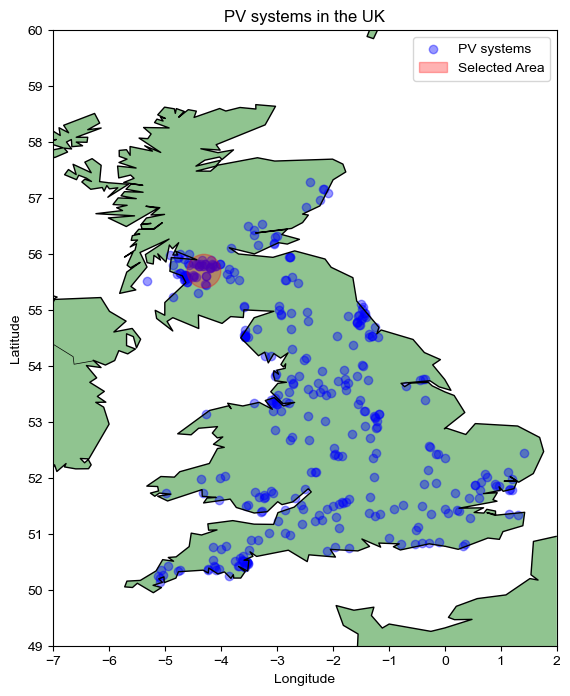

In [6]:
plot_grid(df_location, CIRCLE_COORDS, distance_method='circle', radius=RADIUS)

In [4]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    # season = 'summer',
                    drop_nan=False)

X, y = generator.get_time_series()

N_TASKS = y.size(-1)
NUM_LATENT = 5

==> Loading data
==> Loaded data in: 0 m : 4 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
df = generator.pv_series

In [88]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

def scatter_pv_vals(df, day = '2018-01-31 12:00:00', distance_method='circle', coords=(53.28, -3.05), radius=0.3, ax = None, i=1, fig = None):
    """
    Plot the grid of the UK with the PV systems

    Args:
        df (pd.DataFrame): dataframe containing the PV systems locations
        COORDS (tuple): coordinates of the center of the circle / corners of the polygon
        RADIUS (float): radius of the circle
    """

    
    plt.rcParams['font.family'] = 'Arial'

    map_uk = Basemap(llcrnrlon=-7, llcrnrlat=49, urcrnrlon=2, urcrnrlat=60, resolution='l', ax=ax)

    map_uk.drawcoastlines()
    map_uk.drawcountries()
    map_uk.fillcontinents(color='forestgreen', lake_color='lightblue', alpha=0.5)

    # Plot PV systems
    # get first instance where the datetime column is at 12:00
    df = df[df['datetime'] == day]

    

    if 'latitude_noisy' in df.columns:
        x, y = map_uk(df['longitude_noisy'].values, df['latitude_noisy'].values)
    
    elif 'latitude' in df.columns:
        x, y = map_uk(df['longitude'].values, df['latitude'].values)

    # scatter all the PV systems, but set a color bar based on the current PV value
    pvals = map_uk.scatter(x, y, c=df['PV'].values, cmap='Reds', alpha=0.7, s=20, vmin=0, vmax=1, ax=ax)
    # set values for the color bar to be between 0 and 1 and make it the same height as the map
    if i == 2:
        fig.colorbar(pvals, label='PV value', ax=ax, pad=0.02, fraction=0.05)

    # if distance_method == 'circle':
    #     # a circle representing the desired area
    #     lon, lat = map_uk(coords[1], coords[0])
    #     circle = ax.Circle((lon, lat), radius, color='k', fill=False, label='Selected Area')
    #     ax.add_patch(circle)

    ax.set_xticks(np.arange(-7, 3,))
    ax.set_yticks(np.arange(49.5, 58))

    ax.set_xlabel('Longitude')
    if i == 0:
        ax.set_ylabel('Latitude')
    ax.set_title(f'PV systems in the UK ({day[:-3]})')
    

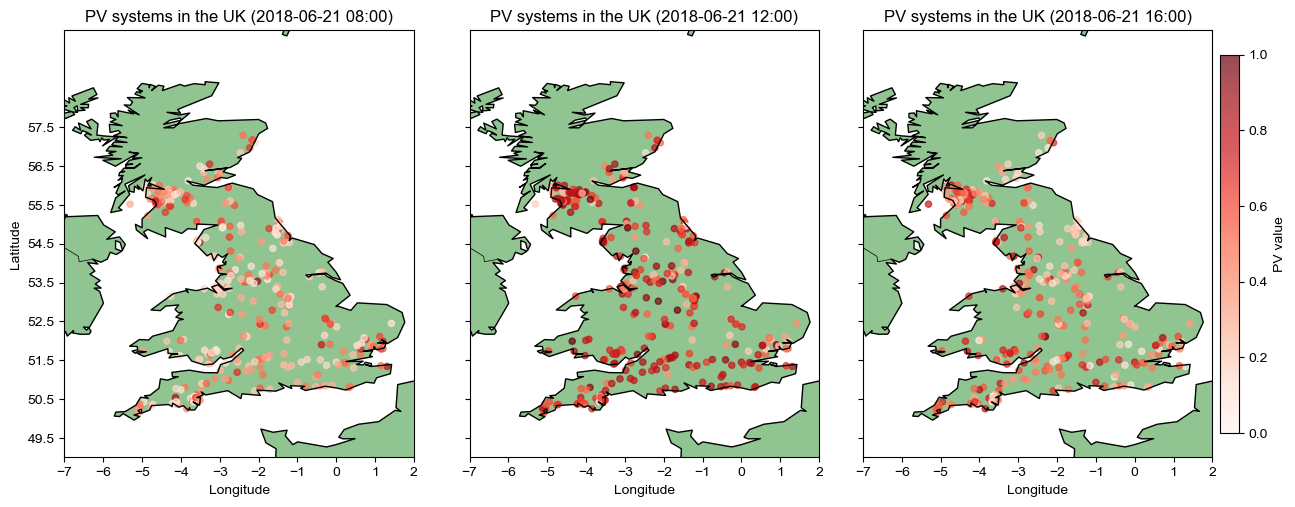

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(13.2, 5), sharey=True)
ax = ax.flatten()
for i, t in enumerate(['2018-06-21 08:00:00', '2018-06-21 12:00:00', '2018-06-21 16:00:00']):
    scatter_pv_vals(df, day=t, ax=ax[i], i=i, fig = fig)



plt.tight_layout()

In [39]:
DAY_INIT = 0 # start of data is 01-01-2018
N_DAYS = 365 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7
N_SYSTEMS = 40
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

In [92]:
time_series_dict = {}
for season in ['winter', 'spring', 'summer', 'fall']:
    generator = PVDataGenerator(n_days=N_DAYS,
                        day_init=DAY_INIT,
                        n_systems=N_SYSTEMS,
                        coords=(53.28, -5.05),
                        radius=2,
                        minute_interval=MINUTE_INTERVAL,
                        day_min=DAY_MIN,
                        day_max=DAY_MAX,
                        folder_name='pv_data',
                        file_name_pv='pv_data_clean.csv',
                        file_name_location='location_data_clean.csv',
                        distance_method='circle',
                        season = season,
                        drop_nan=False)
    
    time_series_dict[f'{season}'] = generator.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 3 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [93]:
# creates list of x and y values for each fold split by a given number of days
season_dict = {}
for key, vals in time_series_dict.items():
    X, y = vals
    x_list, y_list = cross_val_fold(X, y, N_DAYS_FOLD, DAILY_DATA_POINTS)
    x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, MINUTE_INTERVAL, DAY_MIN, DAY_MAX)
    season_dict[key] = PVDataLoader(x_train, y_train), PVDataLoader(x_test, y_test)

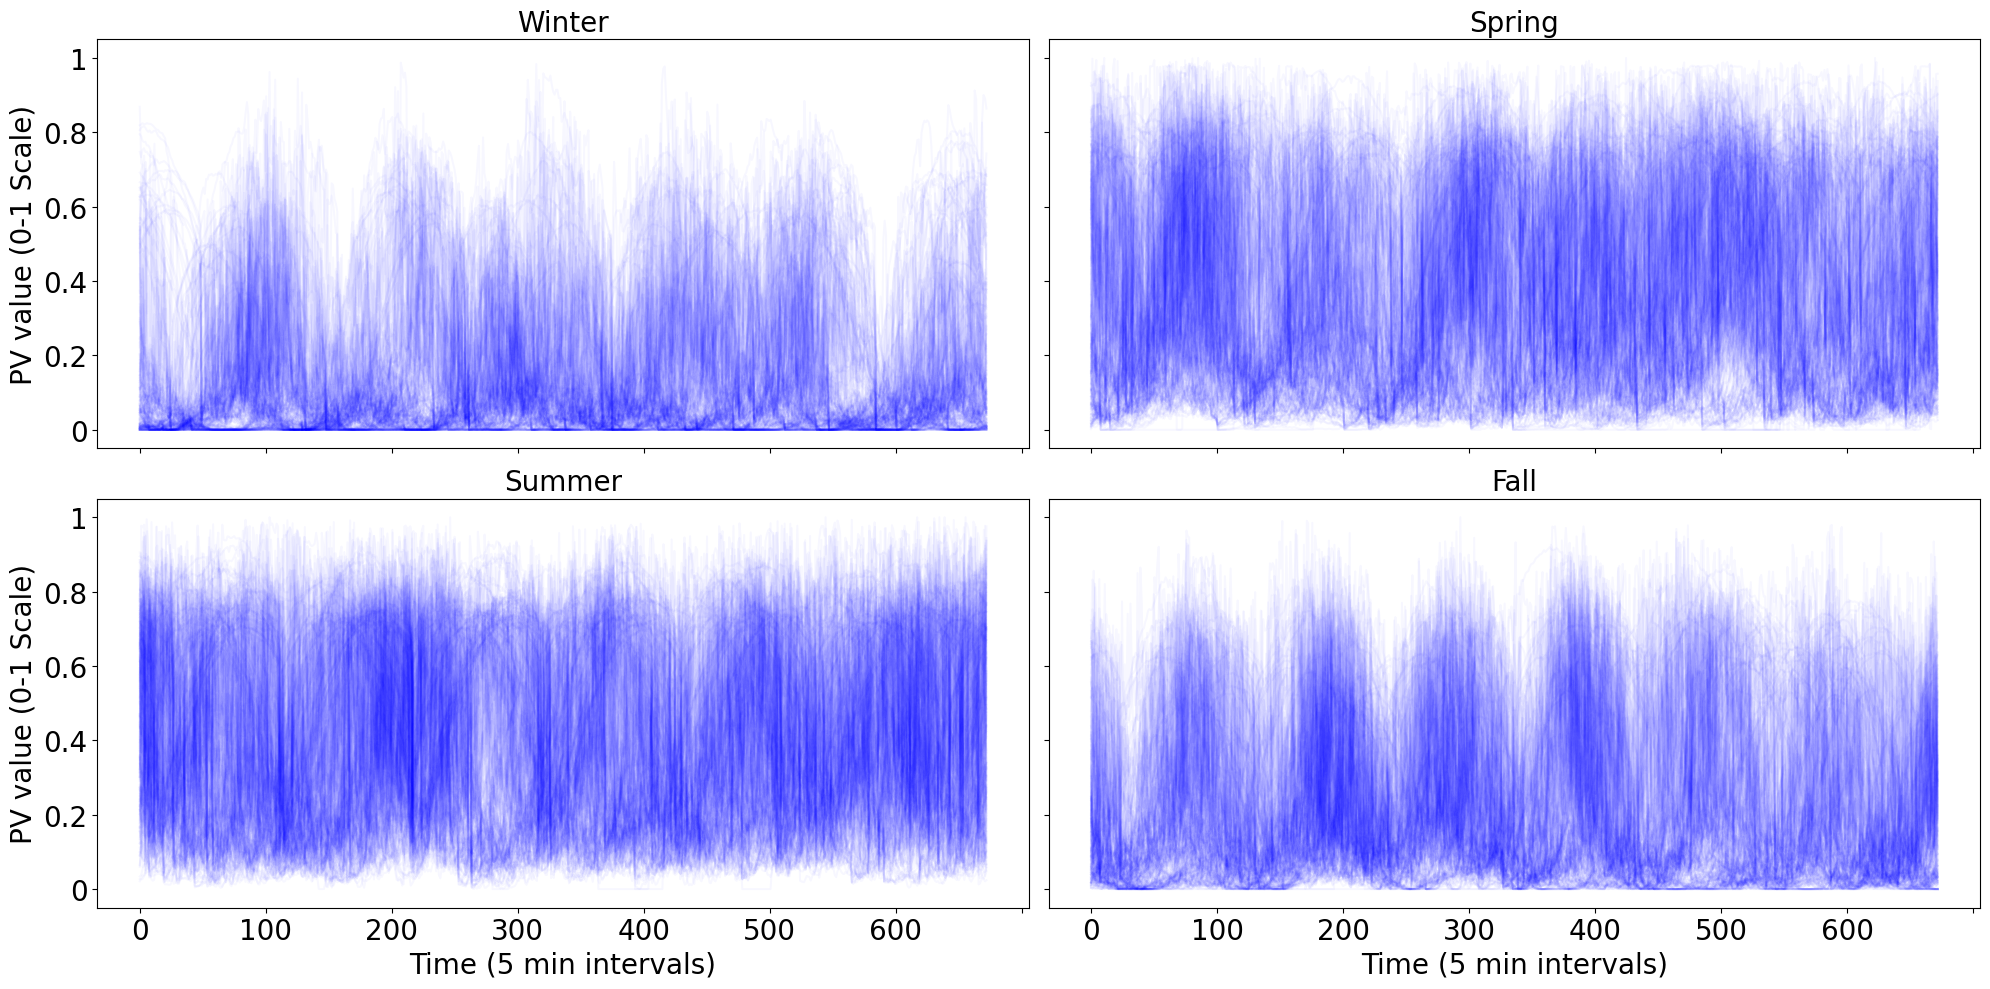

In [100]:
from matplotlib import pyplot as plt
n_max = 0
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharey=True, sharex=True)
ax = ax.flatten()
for i, (key, vals) in enumerate(season_dict.items()):
    for (x_tr, y_tr), (x_te, y_te) in zip(vals[0], vals[1]):
        n = len(x_tr) + len(x_te)
        if n > n_max:
            n_max = n
        # drop constant values
        if len(np.unique(y_tr.numpy())) == 1 or len(y_tr) < 100:
            continue
        # concatenate train and test values
        x = torch.linspace(0, int(N_DAYS_FOLD * DAILY_DATA_POINTS), len(x_tr) + len(x_te))
        y = torch.cat((y_tr, y_te))
        ax[i].plot(x, y, label='PV value', color='b', alpha=0.03)
       
    ax[i].set_title(f'{key.capitalize()}', fontsize=20)

    if i == 0 or i == 2:
        ax[i].set_ylabel('PV value (0-1 Scale)', fontsize=20)
        ax[i].set_yticklabels([0, 0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
    
    if i == 2 or i == 3:
        ax[i].set_xlabel('Time (5 min intervals)', fontsize=20)
        # drop last tick
        ax[i].set_xticklabels([0, 0, 100, 200, 300, 400, 500, 600], fontsize=20)

plt.tight_layout()